# Test Project for Week 07 - Algorithmic Trading
### Author: Hisato Kato
### Revised: 2025/3/15

**Prediction-based Trading & Event-based Backtesting**

Implement a class that uses **event-based backtesting** to backtest the following prediction-based strategy:

* ~~Data from `http://hilpisch.com/ref_eikon_eod_data.csv`.~~  `implemented`
* ~~Select one symbol from the data set.~~  `implemented`
* Create the following features:
    * ~~log return~~ `implemented`
    * ~~direction (up or down)~~ `implemented`
    * log return as 5 categories
    * two SMAs (short and long window)
    * difference between the SMAs
    * two EWMAs (short and long window)
    * difference between the EWMAs
    * two rolling volatilities (short and long window)
* Split the data set into training (70%) and testing data.
* Normalize the training features data to have
    * zero mean and
    * standard deviation of one.
* Normalize the test features data by the same moment values as the training data.
* Create lagged features data for 5 lags.
* Train and (back-)test the following algorithms for directional (long/short) trading (from `scikit-learn`):
    * `GaussianNB()`
    * `LogisticRegression()`
    * `DecisionTreeClassifier()`
    * `SVC()`
    * `MLPClassifier()`
* Compare the performance of the different models numerically.

For the implementation, you can rely e.g. on the Python classes as presented in the PyAlgo class sessions and the resources.

## Imports and setups

In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## The `BacktestBase` class definition copied from the course
### Changed the data URL from 'http://hilpisch.com/pyalgo_eikon_eod_data.csv' to
### 

In [2]:
#
# Python Script with Base Class
# for Event-based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#

class BacktestBase(object):
    ''' Base class for event-based backtesting of trading strategies.

    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to be used
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: float
        amount to be invested either once or per trade
    ftc: float
        fixed transaction costs per trade (buy or sell)
    ptc: float
        proportional transaction costs per trade (buy or sell)

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    plot_data:
        plots the closing price for the symbol
    get_date_price:
        returns the date and price for the given bar
    print_balance:
        prints out the current (cash) balance
    print_net_wealth:
        prints auf the current net wealth
    place_buy_order:
        places a buy order
    place_sell_order:
        places a sell order
    close_out:
        closes out a long or short position
    '''

    def __init__(self, symbol, start, end, amount,
                 ftc=0.0, ptc=0.0, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_amount = amount
        self.amount = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0
        self.position = 0
        self.trades = 0
        self.verbose = verbose
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/ref_eikon_eod_data.csv', # CHANGED
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def plot_data(self, cols=None):
        ''' Plots the closing prices for symbol.
        '''
        if cols is None:
            cols = ['price']
        self.data['price'].plot(figsize=(10, 6), title=self.symbol)

    def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.data.index[bar])[:10]
        price = self.data.price.iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')

    def print_net_wealth(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 57)
        print('Final balance   [$] {:.2f}'.format(self.amount))
        perf = ((self.amount - self.initial_amount) /
                self.initial_amount * 100)
        print('Net Performance [%] {:.2f}'.format(perf))
        print('=' * 57)

#if __name__ == '__main__':
#    bb = BacktestBase('AAPL.O', '2010-1-1', '2019-12-31', 10000)
#    print(bb.data.info())
#    print(bb.data.tail())
#    bb.plot_data()
    # plt.savefig('../../images/ch06/backtestbaseplot.png')


## The `BacktestLongOnly` class definition copied from the course

In [3]:
#
# Python Script with Long Only Class
# for Event-based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
#from BacktestBase import *

class BacktestLongOnly(BacktestBase):

    def run_sma_strategy(self, SMA1, SMA2):
        ''' Backtesting a SMA-based strategy.

        Parameters
        ==========
        SMA1, SMA2: int
            shorter and longer term simple moving average (in days)
        '''
        msg = f'\n\nRunning SMA strategy | {self.symbol} | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 57)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):
            if self.position == 0:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0  # market neutral
        self.close_out(bar)

    def run_momentum_strategy(self, momentum):
        ''' Backtesting a momentum-based strategy.

        Parameters
        ==========
        momentum: int
            number of days for mean return calculation
        '''
        msg = f'\n\nRunning momentum strategy | {self.symbol} | {momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 57)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):
            if self.position == 0:
                if self.data['momentum'].iloc[bar] > 0:
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['momentum'].iloc[bar] < 0:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0  # market neutral
        self.close_out(bar)

    def run_mean_reversion_strategy(self, SMA, threshold):
        ''' Backtesting a mean reversion-based strategy.

        Parameters
        ==========
        SMA: int
            simple moving average in days
        threshold: float
            absolute value for deviation-based signal relative to SMA
        '''
        msg = f'\n\nRunning mean reversion strategy | {self.symbol} | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 57)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):
            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
        self.close_out(bar)


#if __name__ == '__main__':
#    def run_strategies():
#        lobt.run_sma_strategy(42, 252)
#        lobt.run_momentum_strategy(60)
#        lobt.run_mean_reversion_strategy(50, 5)
#    lobt = BacktestLongOnly('AAPL.O', '2010-1-1', '2019-12-31', 10000,
#                            verbose=False)
#    run_strategies()
    # transaction costs: 10 USD fix, 1% variable
#    lobt = BacktestLongOnly('AAPL.O', '2010-1-1', '2019-12-31',
#                            10000, 10.0, 0.01, False)
#    run_strategies()


## The `BacktestLongShort` class definition copied from the course

In [4]:
#
# Python Script with Long Short Class
# for Event-based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
#from BacktestBase import *

class BacktestLongShort(BacktestBase):

    def go_long(self, bar, units=None, amount=None):
        if self.position == -1:
            self.place_buy_order(bar, units=-self.units)
        if units:
            self.place_buy_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_buy_order(bar, amount=amount)

    def go_short(self, bar, units=None, amount=None):
        if self.position == 1:
            self.place_sell_order(bar, units=self.units)
        if units:
            self.place_sell_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_sell_order(bar, amount=amount)

    def run_sma_strategy(self, SMA1, SMA2):
        msg = f'\n\nRunning SMA strategy | {self.symbol} | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 57)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):
            if self.position in [0, -1]:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            elif self.position in [0, 1]:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)

    def run_momentum_strategy(self, momentum):
        msg = f'\n\nRunning momentum strategy | {self.symbol} | {momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 57)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):
            if self.position in [0, -1]:
                if self.data['momentum'].iloc[bar] > 0:
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            elif self.position in [0, 1]:
                if self.data['momentum'].iloc[bar] <= 0:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)

    def run_mean_reversion_strategy(self, SMA, threshold):
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'{self.symbol} | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 57)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):
            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.go_long(bar, amount=self.initial_amount)
                    self.position = 1
                elif (self.data['price'].iloc[bar] >
                        self.data['SMA'].iloc[bar] + threshold):
                    self.go_short(bar, amount=self.initial_amount)
                    self.position = -1
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
            elif self.position == -1:
                if self.data['price'].iloc[bar] <= self.data['SMA'].iloc[bar]:
                    self.place_buy_order(bar, units=-self.units)
                    self.position = 0
        self.close_out(bar)


#if __name__ == '__main__':
#    def run_strategies():
#        lsbt.run_sma_strategy(42, 252)
#        lsbt.run_momentum_strategy(60)
#        lsbt.run_mean_reversion_strategy(50, 5)
#    lsbt = BacktestLongShort('EUR=', '2010-1-1', '2019-12-31', 10000,
#                             verbose=False)
#    run_strategies()
#    # transaction costs: 10 USD fix, 1% variable
#    lsbt = BacktestLongShort('AAPL.O', '2010-1-1', '2019-12-31',
#                             10000, 10.0, 0.01, False)
#    run_strategies()


## Running `BacktestBase`

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2010-01-05 to 2019-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2515 non-null   float64
 1   return  2515 non-null   float64
dtypes: float64(2)
memory usage: 58.9 KB
None
             price    return
Date                        
2019-12-24  284.27  0.000950
2019-12-26  289.91  0.019646
2019-12-27  289.80 -0.000380
2019-12-30  291.52  0.005918
2019-12-31  293.65  0.007280


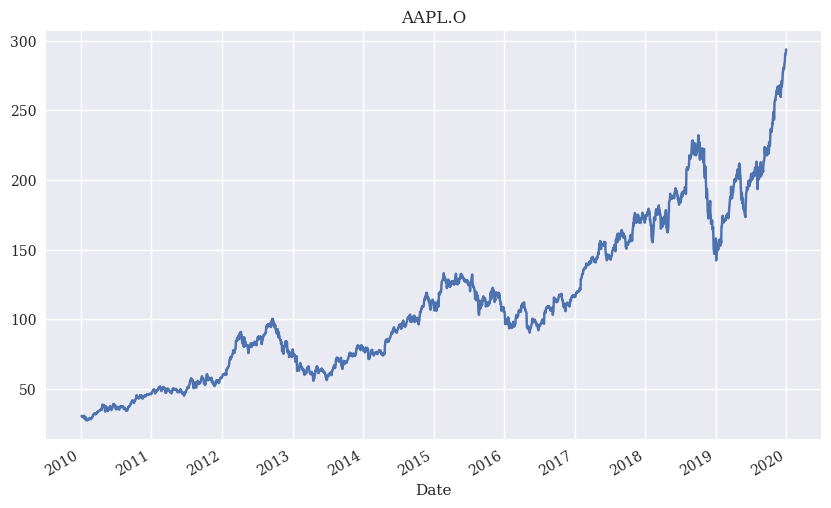

In [5]:
if __name__ == '__main__':
    bb = BacktestBase('AAPL.O', '2010-1-1', '2019-12-31', 10000)
    print(bb.data.info())
    print(bb.data.tail())
    bb.plot_data()


## Running `BacktestLongOnly`

In [6]:
if __name__ == '__main__':
    def run_strategies():
        lobt.run_sma_strategy(42, 252)
        lobt.run_momentum_strategy(60)
        lobt.run_mean_reversion_strategy(50, 5)
    lobt = BacktestLongOnly('AAPL.O', '2010-1-1', '2019-12-31', 10000,
                            verbose=False)
    run_strategies()
    # transaction costs: 10 USD fix, 1% variable
    lobt = BacktestLongOnly('AAPL.O', '2010-1-1', '2019-12-31',
                            10000, 10.0, 0.01, False)
    run_strategies()



Running SMA strategy | AAPL.O | SMA1=42 & SMA2=252
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 56204.95
Net Performance [%] 462.05


Running momentum strategy | AAPL.O | 60 days
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 136716.52
Net Performance [%] 1267.17


Running mean reversion strategy | AAPL.O | SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 53907.99
Net Performance [%] 439.08


Running SMA strategy | AAPL.O | SMA1=42 & SMA2=252
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 51959.62
Net Performance [%] 419.60


Running momentum strategy | AAPL.O | 60 days
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 38074.26
Net Performance [%] 280.74


Running mean reversion strategy | AAPL.O | SMA=50 & thr=5
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 15375.48
Net Performance [%] 53.75


## Running `BacktestLongShort`

In [7]:
if __name__ == '__main__':
    def run_strategies():
        lsbt.run_sma_strategy(42, 252)
        lsbt.run_momentum_strategy(60)
        lsbt.run_mean_reversion_strategy(50, 5)
    lsbt = BacktestLongShort('EUR=', '2010-1-1', '2019-12-31', 10000,
                             verbose=False)
    run_strategies()
    # transaction costs: 10 USD fix, 1% variable
    lsbt = BacktestLongShort('AAPL.O', '2010-1-1', '2019-12-31',
                             10000, 10.0, 0.01, False)
    run_strategies()



Running SMA strategy | EUR= | SMA1=42 & SMA2=252
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 12592.41
Net Performance [%] 25.92


Running momentum strategy | EUR= | 60 days
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] -4304.88
Net Performance [%] -143.05


Running mean reversion strategy | EUR= | SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 5695.36
Net Performance [%] -43.05


Running SMA strategy | AAPL.O | SMA1=42 & SMA2=252
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 38369.65
Net Performance [%] 283.70


Running momentum strategy | AAPL.O | 60 days
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 6883.45
Net Performance [%] -31.17


Running mean reversion strategy | AAPL.O | SMA=50 & thr=5
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] -5110.97
Net Performance [%] -151.11


## Defining an event-based backtesting class

In [10]:
class EventBasedBackTesting(BacktestBase):
    def __init__(self, symbol, start, end, amount,
                 ftc=0.0, ptc=0.0, verbose=True):
        super(EventBasedBackTesting, self).__init__(symbol, start, end, amount,
                 ftc, ptc, verbose)
        self._prepare_features()
        
    def _prepare_features(self):
        self.data['direction'] = np.sign(self.data['return']).astype(int)
        
    def func1(self): # template
        return 1

    def func2(self): # under development
        # Train-test split
        train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=0) # py4fi2nd ch. 13 SVC 
        
        return 2

## Running the event-based backtesting class

In [11]:
ebbt = EventBasedBackTesting('GS.N', '2010-1-1', '2019-12-31', 10000)
# symbol GS.N = Goldman Sachs

In [12]:
ebbt.func1()

1

In [13]:
ebbt.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2388 entries, 2010-01-05 to 2019-07-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      2388 non-null   float64
 1   return     2388 non-null   float64
 2   direction  2388 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 74.6 KB


In [14]:
ebbt.data.head()

,price,return,direction
Date,,,
2010-01-05,176.14,0.017525,1
2010-01-06,174.26,-0.010731,-1
2010-01-07,177.67,0.019379,1
2010-01-08,174.31,-0.019093,-1
2010-01-11,171.56,-0.015902,-1


In [18]:
ebbt.data.tail()

,price,return
Date,,
2019-06-25,196.06,-0.007267
2019-06-26,197.01,0.004834
2019-06-27,199.32,0.011657
2019-06-28,204.60,0.026145
2019-07-01,206.86,0.010985
